In [ ]:
import os
import numpy as np
import json
from collections import defaultdict
import matplotlib.pyplot as plt

In [ ]:
def plot_radius_sensitivity(logs, organs=None, augmentations=None, save_path=None,
                            normalize=False, color_map=None):
    """
    Plot Dice variation with radius for each augmentation type.
    
    Parameters
    ----------
    logs : dict
        Nested structure logs[organ][augmentation][radius] = [list of Dice scores].
    organs : list of str, optional
        Organs to plot (subset of logs.keys()).
    augmentations : list of str, optional
        Augmentations to include (subset of all available).
    save_path : str, optional
        Path to save plot.
    normalize : bool, optional
        Normalize each curve by the organ’s no-augment mean (if available).
    color_map : dict, optional
        Color map per organ for consistency with other figures.
    """
    
    if organs is None:
        organs = list(logs.keys())
    if augmentations is None:
        # infer all augmentation types
        augmentations = sorted({aug for org in logs.values() for aug in org.keys()})
    
    if color_map is None:
        color_map = {
            'liver': '#2E86AB',
            'left_kidney': '#F18F01',
            'left_adrenal_gland': '#C73E1D',
            'portal_vein_and_splenic_vein': '#6CBE45'
        }

    fig, axes = plt.subplots(1, len(augmentations), figsize=(4 * len(augmentations), 3), sharey=True)
    if len(augmentations) == 1:
        axes = [axes]

    for j, aug in enumerate(augmentations):
        ax = axes[j]
        for organ in organs:
            if organ not in logs or aug not in logs[organ]:
                continue
            r_dict = logs[organ][aug]
            radii = sorted(r_dict.keys())
            means = [np.mean(r_dict[r]) for r in radii]
            stds = [np.std(r_dict[r]) for r in radii]

            # Normalize if requested
            if normalize and 'no-augment' in logs.get(organ, {}):
                baseline_vals = []
                for val_list in logs[organ]['no-augment'].values():
                    baseline_vals.extend(val_list)
                baseline_mean = np.mean(baseline_vals)
                means = [m / baseline_mean for m in means]
                stds = [s / baseline_mean for s in stds]

            c = color_map.get(organ, None)
            ax.plot(radii, means, label=organ, color=c, linewidth=2)
            ax.fill_between(radii, np.array(means) - np.array(stds),
                            np.array(means) + np.array(stds),
                            color=c, alpha=0.15)

        ax.set_title(aug.replace('-', ' ').title(), fontsize=12, weight='bold')
        ax.set_xlabel("Radius", fontsize=10)
        if j == 0:
            ax.set_ylabel("Mean Dice", fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.4)
        ax.set_ylim(0, 1.05)

    # Common legend
    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=len(organs),
               fontsize=9, frameon=False, bbox_to_anchor=(0.5, 1.05))
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    if save_path:
        plt.savefig(save_path, dpi=400, bbox_inches='tight')
    else:
        plt.show()
  

In [ ]:
# Load the JSON file
with open('evals/all_logs.json', 'r') as f:
    data_aug = json.load(f)
with open('evals/all_logs_no-aug.json', 'r') as f:
    data_noaug = json.load(f)
with open('evals/all_logs_shift.json', 'r') as f:
    data_shift = json.load(f) 

In [ ]:
# -------------------------
# Global trend across organs (scientifically-correct handling for "hole")
# -------------------------
aug_types = ['dilate', 'erode', 'hole']

# infer max radius from data_aug to avoid hard-coding
try:
    max_radius = max(int(r) for org in data_aug.values() for augd in org.values() for r in augd.keys())
except Exception:
    max_radius = 10

radii_numeric = list(range(1, max_radius + 1))  # 1..N (no-aug handled separately)

# collect global no-aug baseline values across all organs
baseline_vals = []
for organ in data_noaug:
    vals = data_noaug[organ].get('no-aug') or data_noaug[organ].get('no_augment') or []
    baseline_vals.extend(vals)
baseline_mean = np.mean(baseline_vals) if len(baseline_vals) else np.nan
baseline_std = np.std(baseline_vals) if len(baseline_vals) else np.nan

fig, axes = plt.subplots(1, len(aug_types), figsize=(4 * len(aug_types), 3), sharey=True)
if len(aug_types) == 1:
    axes = [axes]

for j, aug in enumerate(aug_types):
    ax = axes[j]
    means = []
    stds = []

    if aug == 'hole':
        # For "hole", treat listed numbers as boundary thicknesses that approach the true mask:
        # plot thicknesses in ascending order, with the no-aug (true mask) value placed at the rightmost end.
        for r in radii_numeric:
            vals = []
            for organ, aug_data in data_aug.items():
                if aug in aug_data and str(r) in aug_data[aug]:
                    vals.extend(aug_data[aug][str(r)])
            if len(vals):
                means.append(np.mean(vals))
                stds.append(np.std(vals))
            else:
                means.append(np.nan)
                stds.append(np.nan)
        # append no-aug at the rightmost position
        means.append(baseline_mean)
        stds.append(baseline_std)

        x_pos = np.arange(len(means))  # 0..len-1
        xtick_labels = [str(r) for r in radii_numeric] + ['Orig.\nMask']
        ax.set_xlabel("Boundary thickness", fontsize=10)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(xtick_labels)
        ax.set_xlim(-0.5, len(means) - 0.5)
        aug = "Boundary-preserved Mask Erode"
    else:
        # For other augmentations, keep the conventional 0 = no-aug at left
        radii_with_zero = [0] + radii_numeric
        for r in radii_with_zero:
            if r == 0:
                means.append(baseline_mean)
                stds.append(baseline_std)
            else:
                vals = []
                for organ, aug_data in data_aug.items():
                    if aug in aug_data and str(r) in aug_data[aug]:
                        vals.extend(aug_data[aug][str(r)])
                if len(vals):
                    means.append(np.mean(vals))
                    stds.append(np.std(vals))
                else:
                    means.append(np.nan)
                    stds.append(np.nan)

        x_pos = np.array(radii_with_zero)
        ax.set_xlabel("Radius (0 = original mask)", fontsize=10)
        ax.set_xticks(x_pos)
        ax.set_xlim(0, float(max(radii_with_zero)))

    means = np.array(means)
    stds = np.array(stds)

    ax.plot(x_pos, means, color='#2E86AB', linewidth=2)
    ax.fill_between(x_pos, means - stds, means + stds, color='#2E86AB', alpha=0.15)
    ax.set_title(aug.title(), fontsize=12, weight='bold')
    if j == 0:
        ax.set_ylabel("Mean DSC", fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.set_ylim(0, 1.0)

plt.tight_layout()
# save and show
out_path = 'plots/global_trends.png'
plt.savefig(out_path, dpi=300, bbox_inches='tight')
print(f"Saved global trends plot to {out_path}")
plt.show()

In [ ]:
# Per-organ trends: one figure per organ with 3 subplots (dilate, erode, hole)
# Make "hole" scientifically-correct: radius -> boundary thickness and place no-aug at rightmost end.
radii_numeric = list(range(1, max_radius + 1))  # 1..max_radius

organs = sorted(set(list(data_aug.keys()) + list(data_noaug.keys())))
for organ in organs:
    fig, axes = plt.subplots(1, len(aug_types), figsize=(4 * len(aug_types), 3), sharey=True)
    if len(aug_types) == 1:
        axes = [axes]

    # organ-specific baseline (handle naming variants)
    baseline_list = data_noaug.get(organ, {}).get('no-aug') or data_noaug.get(organ, {}).get('no_augment') or []
    baseline_mean = np.mean(baseline_list) if len(baseline_list) else np.nan
    baseline_std = np.std(baseline_list) if len(baseline_list) else np.nan

    for j, aug_t in enumerate(aug_types):
        ax = axes[j]
        if aug_t == 'hole':
            # compute means/stds for ascending boundary thickness and append no-aug at right
            means = []
            stds = []
            for r in radii_numeric:
                vals = data_aug.get(organ, {}).get(aug_t, {}).get(str(r)) or []
                if len(vals):
                    means.append(np.mean(vals))
                    stds.append(np.std(vals))
                else:
                    means.append(np.nan)
                    stds.append(np.nan)
            # append original mask (no-aug) at the rightmost end
            means.append(baseline_mean)
            stds.append(baseline_std)

            x_pos = np.arange(len(means))
            xtick_labels = [str(r) for r in radii_numeric] + ['Orig.\nMask']
            ax.plot(x_pos, np.array(means), color='#2E86AB', linewidth=2)
            ax.fill_between(x_pos, np.array(means) - np.array(stds), np.array(means) + np.array(stds),
                            color='#2E86AB', alpha=0.15)

            ax.set_xlabel("Boundary thickness", fontsize=10)
            ax.set_xticks(x_pos)
            ax.set_xticklabels(xtick_labels)
            ax.set_xlim(-0.5, len(means) - 0.5)
            ax.set_title("Boundary-Preserved Mask Erode", fontsize=12, weight='bold')
        else:
            # conventional handling: 0 = no-aug at left
            radii_with_zero = [0] + radii_numeric
            means = []
            stds = []
            for r in radii_with_zero:
                if r == 0:
                    means.append(baseline_mean)
                    stds.append(baseline_std)
                else:
                    vals = data_aug.get(organ, {}).get(aug_t, {}).get(str(r)) or []
                    if len(vals):
                        means.append(np.mean(vals))
                        stds.append(np.std(vals))
                    else:
                        means.append(np.nan)
                        stds.append(np.nan)

            x = np.array(radii_with_zero)
            means = np.array(means)
            stds = np.array(stds)

            ax.plot(x, means, color='#2E86AB', linewidth=2)
            ax.fill_between(x, means - stds, means + stds, color='#2E86AB', alpha=0.15)

            ax.set_xlabel("Radius (0 = no-aug)", fontsize=10)
            ax.set_xticks(radii_with_zero)
            ax.set_xlim(0, float(max(radii_with_zero)))
            ax.set_title(aug_t.title(), fontsize=12, weight='bold')

        ax.grid(True, linestyle='--', alpha=0.4)
        ax.set_ylim(0, 1.0)
        if j == 0:
            ax.set_ylabel("Mean Dice", fontsize=10)

    plt.suptitle(organ.replace('_', ' ').title(), fontsize=14, y=1.02)
    plt.tight_layout()
    out_path = f"plots/{organ}_trends.png"
    os.makedirs(os.path.dirname(out_path) or ".", exist_ok=True)
    plt.savefig(out_path, dpi=300, bbox_inches='tight')
    print(f"Saved {out_path}")
    plt.show()
    plt.close(fig)


In [ ]:
import re

# Utilities to load the alternate-schema logs and plot the same figures as above.
# Assumes os, json, np, defaultdict, plt are already imported in the notebook.

def build_logs_from_dir(log_dir, mapper_path, radius_pattern=None, no_aug_filenames=None):
    """
    Load files with schema: {filepath: {label_idx: dice_score}} and mapper (i.e. dataset.json) mapping label_idx -> organ name.
    Produces:
      - data_aug: dict[organ][augment][str(radius)] = [dice_scores...]
      - data_noaug: dict[organ]['no-aug'] = [dice_scores...]
      - logs_for_plot: dict[organ][augment][radius_int] = [dice_scores...] (compatible with plot_radius_sensitivity)
    """
    if no_aug_filenames is None:
        no_aug_filenames = {'no-aug.json', 'no_aug.json', 'no-augment.json'}
    if radius_pattern is None:
        # matches "<augment>_radius=<r>.json", e.g. "hole_radius=3.json" or "dilate_radius=10.json"
        radius_pattern = re.compile(r'(?P<aug>[\w\-]+)_radius=(?P<r>\d+)\.json$')

    # load mapper
    with open(mapper_path, 'r') as mf:
        mapper = json.load(mf)
    mapper = mapper["labels"]

    # normalize mapper keys to strings
    mapper_norm = {str(k): v for k, v in mapper.items()}

    data_aug = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    data_noaug = defaultdict(lambda: defaultdict(list))
    logs_for_plot = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

    for fname in sorted(os.listdir(log_dir)):
        fpath = os.path.join(log_dir, fname)
        if not os.path.isfile(fpath):
            continue

        # no-aug files
        if fname in no_aug_filenames:
            try:
                with open(fpath, 'r') as f:
                    file_dict = json.load(f)
            except Exception:
                continue
            # file_dict: {filepath: {label_idx: dice_score}}
            for filekey, label_map in file_dict.items():
                if not isinstance(label_map, dict):
                    continue
                for label_idx, score in label_map.items():
                    organ = mapper_norm.get(str(label_idx))
                    if organ is None:
                        continue
                    # keep both naming conventions used across notebook
                    data_noaug[organ]['no-aug'].append(score)
                    # also keep for plot function normalization under 'no-augment' keyed by radius 0
                    logs_for_plot[organ]['no-augment'][0].append(score)
            continue

        # augmentation files
        m = radius_pattern.search(fname)
        if not m:
            # skip non-matching names
            continue
        aug = m.group('aug')
        r = int(m.group('r'))

        try:
            with open(fpath, 'r') as f:
                file_dict = json.load(f)
        except Exception:
            continue

        for filekey, label_map in file_dict.items():
            if not isinstance(label_map, dict):
                continue
            for label_idx, score in label_map.items():
                organ = mapper_norm.get(str(label_idx))
                if organ is None:
                    continue
                data_aug[organ][aug][str(r)].append(score)
                logs_for_plot[organ][aug][r].append(score)

    # convert defaultdicts to normal dicts for nicer repr/consumption
    def dd_to_dict(d):
        if isinstance(d, defaultdict):
            d = {k: dd_to_dict(v) for k, v in d.items()}
        elif isinstance(d, dict):
            d = {k: dd_to_dict(v) for k, v in d.items()}
        return d

    return dd_to_dict(data_aug), dd_to_dict(data_noaug), dd_to_dict(logs_for_plot)


# Example usage: adjust paths as needed
log_directory = "evals_nninteractive"   # directory containing the "{aug}_radius={r}.json" and "no-aug.json" files
mapper_json = "/playpen/soumitri/data/BTCV/dataset.json"         # label_idx -> organ name mapping

data_aug_new, data_noaug_new, logs_for_plot = build_logs_from_dir(log_directory, mapper_json)

# If you want to reuse the earlier global/per-organ plotting cells' style,
# we recreate the same plotting loops (global and per-organ) using the newly built dicts.

# Ensure output directory
out_dir = "plots_nninteractive"
os.makedirs(out_dir, exist_ok=True)

# Global trends (aggregate across organs)
aug_types = sorted({aug for organ in data_aug_new.values() for aug in organ.keys()})
# infer max radius across files
all_radii = set()
for organ in data_aug_new.values():
    for aug in organ.values():
        all_radii.update({int(r) for r in aug.keys()})
max_radius = max(all_radii) if len(all_radii) else 8
radii = list(range(0, max_radius + 1))  # 0 -> no-aug baseline

# collect global no-aug baseline values across all organs
baseline_vals = []
for organ_vals in data_noaug_new.values():
    baseline_vals.extend(organ_vals.get('no-aug', []))
baseline_mean = np.mean(baseline_vals) if len(baseline_vals) else np.nan
baseline_std = np.std(baseline_vals) if len(baseline_vals) else np.nan

fig, axes = plt.subplots(1, len(aug_types), figsize=(4 * len(aug_types), 3), sharey=True)
if len(aug_types) == 1:
    axes = [axes]

for j, aug in enumerate(aug_types):
    ax = axes[j]
    # global: compute means/stds
    means = []
    stds = []
    if aug == 'hole':
        # For boundary-preserved erode, plot boundary thickness (1..max_radius) and put original mask as last tick
        for r in range(1, max_radius + 1):
            vals = []
            for organ, aug_data in data_aug_new.items():
                if aug in aug_data and str(r) in aug_data[aug]:
                    vals.extend(aug_data[aug][str(r)])
            if len(vals):
                means.append(np.mean(vals))
                stds.append(np.std(vals))
            else:
                means.append(np.nan)
                stds.append(np.nan)
        # append baseline (original mask) as the last point
        means.append(baseline_mean)
        stds.append(baseline_std)
        x = np.arange(len(means))  # 0..max_radius (last index is original mask)
        xtick_labels = [str(i) for i in range(1, max_radius + 1)] + ['Orig.\nMask']
        ax.set_xticks(x)
        ax.set_xticklabels(xtick_labels)
        ax.set_xlabel("Boundary thickness", fontsize=10)
        ax.set_xlim(0, float(max_radius))
        aug = "Boundary-Preserved Mask Erode"
    else:
        # Standard: radius 0 = no-aug baseline, then 1..max_radius
        for r in range(0, max_radius + 1):
            if r == 0:
                means.append(baseline_mean)
                stds.append(baseline_std)
            else:
                vals = []
                for organ, aug_data in data_aug_new.items():
                    if aug in aug_data and str(r) in aug_data[aug]:
                        vals.extend(aug_data[aug][str(r)])
                if len(vals):
                    means.append(np.mean(vals))
                    stds.append(np.std(vals))
                else:
                    means.append(np.nan)
                    stds.append(np.nan)
        x = np.array(list(range(0, max_radius + 1)))
        ax.set_xticks(x)
        ax.set_xlim(0, float(max_radius))
        ax.set_xlabel("Radius (0 = no-aug)", fontsize=10)

    means = np.array(means)
    stds = np.array(stds)

    ax.plot(x, means, color='#2E86AB', linewidth=2)
    ax.fill_between(x, means - stds, means + stds, color='#2E86AB', alpha=0.15)
    ax.set_title(aug.title(), fontsize=12, weight='bold')
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.set_ylim(0, 1.0)
    if j == 0:
        ax.set_ylabel("Mean Dice (global)", fontsize=10)

plt.tight_layout()
out_path = os.path.join(out_dir, 'global_trends_nninteractive.png')
plt.savefig(out_path, dpi=1200, bbox_inches='tight')
print(f"Saved global trends plot to {out_path}")
plt.show()
plt.close(fig)


# Per-organ trends
radii = list(range(0, max_radius + 1))

organs = sorted(set(list(data_aug_new.keys()) + list(data_noaug_new.keys())))
for organ in organs:
    fig, axes = plt.subplots(1, max(1, len(aug_types)), figsize=(4 * len(aug_types), 3), sharey=True)
    if len(aug_types) == 1:
        axes = [axes]

    # organ-specific baseline
    baseline_list = data_noaug_new.get(organ, {}).get('no-aug') or []
    baseline_mean = np.mean(baseline_list) if len(baseline_list) else np.nan
    baseline_std = np.std(baseline_list) if len(baseline_list) else np.nan

    for j, aug_t in enumerate(aug_types):
        ax = axes[j]
        means = []
        stds = []

        if aug_t == 'hole':
            # boundary-preserved erode: plot thickness 1..max_radius, then original mask as last point
            for r in range(1, max_radius + 1):
                vals = data_aug_new.get(organ, {}).get(aug_t, {}).get(str(r)) or []
                if len(vals):
                    means.append(np.mean(vals))
                    stds.append(np.std(vals))
                else:
                    means.append(np.nan)
                    stds.append(np.nan)
            # append baseline (original mask) as last point
            means.append(baseline_mean)
            stds.append(baseline_std)

            x = np.arange(len(means))
            xtick_labels = [str(i) for i in range(1, max_radius + 1)] + ['Orig.\nMask']
            ax.set_xticks(x)
            ax.set_xticklabels(xtick_labels)
            ax.set_xlabel("Boundary thickness", fontsize=10)
            ax.set_xlim(0, float(max_radius))
            ax.set_title("Boundary-Preserved Mask Erode", fontsize=12, weight='bold')
        else:
            # Standard: radius 0 = no-aug baseline, then 1..max_radius
            for r in range(0, max_radius + 1):
                if r == 0:
                    means.append(baseline_mean)
                    stds.append(baseline_std)
                else:
                    vals = data_aug_new.get(organ, {}).get(aug_t, {}).get(str(r)) or []
                    if len(vals):
                        means.append(np.mean(vals))
                        stds.append(np.std(vals))
                    else:
                        means.append(np.nan)
                        stds.append(np.nan)

            x = np.array(list(range(0, max_radius + 1)))
            ax.set_xticks(x)
            ax.set_xlim(0, float(max_radius))
            ax.set_xlabel("Radius (0 = no-aug)", fontsize=10)
            ax.set_title(aug_t.title(), fontsize=12, weight='bold')

        means = np.array(means)
        stds = np.array(stds)

        ax.plot(x, means, color='#2E86AB', linewidth=2)
        ax.fill_between(x, means - stds, means + stds, color='#2E86AB', alpha=0.15)
        ax.grid(True, linestyle='--', alpha=0.4)
        ax.set_ylim(0, 1.0)
        if j == 0:
            ax.set_ylabel("Mean Dice", fontsize=10)

    plt.suptitle(organ.replace('_', ' ').title(), fontsize=14, y=1.02)
    plt.tight_layout()
    out_path = os.path.join(out_dir, f"{organ}_trends_nninteractive.png")
    plt.savefig(out_path, dpi=1200, bbox_inches='tight')
    print(f"Saved {out_path}")
    plt.show()
    plt.close(fig)


# Optionally: you can also call plot_radius_sensitivity(logs_for_plot, organs=None, augmentations=None)
# to get the multi-organ panel visualization (it expects logs[organ][aug][radius] scheme).
# Example:
# plot_radius_sensitivity(logs_for_plot, organs=None, augmentations=None, save_path=os.path.join(out_dir, "multi_organ_panel.png"))

Saved plots_combined_png/combined_global_trends.png


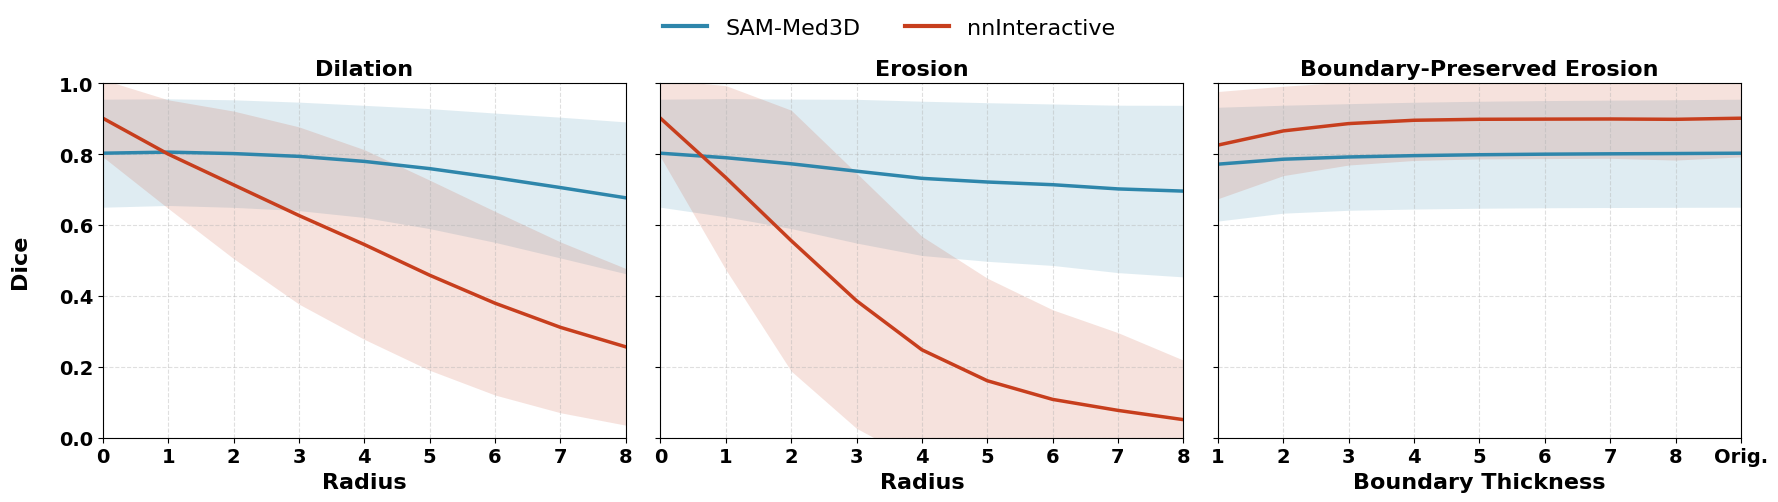

Saved plots_combined_png/aorta_combined_trends.png
Saved plots_combined_png/esophagus_combined_trends.png
Saved plots_combined_png/gallbladder_combined_trends.png
Saved plots_combined_png/inferior_vena_cava_combined_trends.png
Saved plots_combined_png/left_adrenal_gland_combined_trends.png
Saved plots_combined_png/left_kidney_combined_trends.png
Saved plots_combined_png/liver_combined_trends.png
Saved plots_combined_png/pancreas_combined_trends.png
Saved plots_combined_png/portal_vein_and_splenic_vein_combined_trends.png
Saved plots_combined_png/right_adrenal_gland_combined_trends.png
Saved plots_combined_png/right_kidney_combined_trends.png
Saved plots_combined_png/spleen_combined_trends.png
Saved plots_combined_png/stomach_combined_trends.png


In [83]:
from matplotlib.lines import Line2D

# Combined plots with radius clipped to 8, clearer legend, bigger figures, and per-organ y-axis auto-scaling.

# Clip max radius to 8
MAX_RADIUS_CLIP = 8

# font sizes / weights for axis values and labels
TICK_LABELSIZE = 14
TICK_LABELWEIGHT = 'bold'
AX_LABELSIZE = 16
AX_LABELWEIGHT = 'bold'
LEGEND_FONTSIZE = 16
PER_ORG_LEGEND_FONTSIZE = 14

# apply some global rc settings (keeps defaults consistent)
plt.rcParams.update({
    'xtick.labelsize': TICK_LABELSIZE,
    'ytick.labelsize': TICK_LABELSIZE,
    'axes.labelsize': AX_LABELSIZE,
    'axes.labelweight': AX_LABELWEIGHT,
    'legend.fontsize': LEGEND_FONTSIZE,
    'font.size': TICK_LABELSIZE
})

models = [
    ("SAM-Med3D", data_aug, data_noaug, "#2E86AB"),
    ("nnInteractive", data_aug_new, data_noaug_new, "#C73E1D")
]

def max_radius_from(d):
    rs = set()
    for organ in d.values():
        for aug_vals in organ.values():
            for r in aug_vals.keys():
                try:
                    rs.add(int(r))
                except Exception:
                    pass
    return max(rs) if rs else 0

max_radii = [max_radius_from(m[1]) for m in models]
max_radius_combined = min(max(max_radii) if max_radii else 8, MAX_RADIUS_CLIP)
radii_numeric = list(range(1, max_radius_combined + 1))
radii_with_zero = [0] + radii_numeric

aug_types_combined = sorted({aug for m in models for organ in (m[1].values()) for aug in organ.keys()})
if not aug_types_combined:
    aug_types_combined = ['dilate', 'erode', 'hole']

os.makedirs("plots_combined", exist_ok=True)

def baseline_stats(model_noaug):
    vals = []
    for organ_vals in model_noaug.values():
        vals.extend(organ_vals.get('no-aug', []) or [])
    if len(vals):
        return np.mean(vals), np.std(vals)
    return np.nan, np.nan

# helper to bold/enlarge tick labels on an axis
def enhance_ticks(ax):
    for lbl in ax.get_xticklabels():
        lbl.set_fontsize(TICK_LABELSIZE)
        lbl.set_fontweight(TICK_LABELWEIGHT)
    for lbl in ax.get_yticklabels():
        lbl.set_fontsize(TICK_LABELSIZE)
        lbl.set_fontweight(TICK_LABELWEIGHT)

# GLOBAL combined trends (bigger figure)
fig, axes = plt.subplots(1, len(aug_types_combined), figsize=(6 * len(aug_types_combined), 5), sharey=True)
if len(aug_types_combined) == 1:
    axes = [axes]

for j, aug in enumerate(aug_types_combined):
    ax = axes[j]
    for model_name, m_aug, m_noaug, color in models:
        means = []
        stds = []
        if aug == 'hole':
            for r in radii_numeric:
                vals = []
                for organ, aug_data in m_aug.items():
                    if aug in aug_data and str(r) in aug_data[aug]:
                        vals.extend(aug_data[aug][str(r)])
                means.append(np.mean(vals) if len(vals) else np.nan)
                stds.append(np.std(vals) if len(vals) else np.nan)
            baseline_mean, baseline_std = baseline_stats(m_noaug)
            means.append(baseline_mean)
            stds.append(baseline_std)
            x = np.arange(len(means))
            xtick_labels = [str(r) for r in radii_numeric] + ['Orig.']
            ax.set_xticks(x)
            ax.set_xticklabels(xtick_labels)
            ax.set_xlabel("Boundary Thickness", fontsize=AX_LABELSIZE, weight=AX_LABELWEIGHT)
            ax.set_xlim(0, float(len(means) - 1))
        else:
            for r in radii_with_zero:
                if r == 0:
                    bm, bs = baseline_stats(m_noaug)
                    means.append(bm); stds.append(bs)
                else:
                    vals = []
                    for organ, aug_data in m_aug.items():
                        if aug in aug_data and str(r) in aug_data[aug]:
                            vals.extend(aug_data[aug][str(r)])
                    means.append(np.mean(vals) if len(vals) else np.nan)
                    stds.append(np.std(vals) if len(vals) else np.nan)
            x = np.array(radii_with_zero)
            ax.set_xticks(x)
            ax.set_xlim(0, float(max(radii_with_zero)))
            ax.set_xlabel("Radius", fontsize=AX_LABELSIZE, weight=AX_LABELWEIGHT)

        means = np.array(means)
        stds = np.array(stds)
        ax.plot(x, means, label=model_name, color=color, linewidth=2.5)
        ax.fill_between(x, means - stds, means + stds, color=color, alpha=0.15, linewidth=0)

    # enhance tick label appearance
    enhance_ticks(ax)

    if aug == 'dilate': aug = 'Dilation'
    elif aug == 'erode': aug = 'Erosion'
    ax.set_title(aug.title() if aug != 'hole' else "Boundary-Preserved Erosion", fontsize=16, weight='bold')
    if j == 0:
        ax.set_ylabel("Dice\n", fontsize=AX_LABELSIZE, weight=AX_LABELWEIGHT)
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.set_ylim(0, 1.0)

# explicit legend using model names/colors
legend_handles = [Line2D([0], [0], color=m[3], lw=3) for m in models]
legend_labels = [m[0] for m in models]
fig.legend(legend_handles, legend_labels, loc='upper center', ncol=len(models), fontsize=LEGEND_FONTSIZE, frameon=False, bbox_to_anchor=(0.5, 1.03))

plt.tight_layout(rect=[0, 0, 1, 0.95])
out_global = "plots_combined_png/combined_global_trends.png"
plt.savefig(out_global, format='png', dpi=600, bbox_inches='tight')
print(f"Saved {out_global}")
plt.show()
plt.close(fig)


# PER-ORGAN combined trends (bigger figures, auto y-limits)
organs_all = sorted(set(list(data_aug.keys()) + list(data_noaug.keys()) + list(data_aug_new.keys()) + list(data_noaug_new.keys())))

for organ in organs_all:
    fig, axes = plt.subplots(1, len(aug_types_combined), figsize=(6 * len(aug_types_combined), 5), sharey=False)
    if len(aug_types_combined) == 1:
        axes = [axes]

    per_model_baseline = {}
    for model_name, m_aug, m_noaug, color in models:
        bl = m_noaug.get(organ, {}).get('no-aug') or []
        per_model_baseline[model_name] = (np.mean(bl) if len(bl) else np.nan, np.std(bl) if len(bl) else np.nan)

    for j, aug in enumerate(aug_types_combined):
        ax = axes[j]
        # collect values to auto-scale y-axis
        collected_vals = []

        for model_name, m_aug, m_noaug, color in models:
            means = []
            stds = []
            if aug == 'hole':
                for r in radii_numeric:
                    vals = m_aug.get(organ, {}).get(aug, {}).get(str(r)) or []
                    means.append(np.mean(vals) if len(vals) else np.nan)
                    stds.append(np.std(vals) if len(vals) else np.nan)
                bm, bs = per_model_baseline[model_name]
                means.append(bm); stds.append(bs)
                x = np.arange(len(means))
                xtick_labels = [str(r) for r in radii_numeric] + ['Orig.']
                ax.set_xticks(x)
                ax.set_xticklabels(xtick_labels)
                ax.set_xlabel("Boundary Thickness", fontsize=AX_LABELSIZE, weight=AX_LABELWEIGHT)
                ax.set_xlim(0, float(len(means) - 1))
            else:
                for r in radii_with_zero:
                    if r == 0:
                        bm, bs = per_model_baseline[model_name]
                        means.append(bm); stds.append(bs)
                    else:
                        vals = m_aug.get(organ, {}).get(aug, {}).get(str(r)) or []
                        means.append(np.mean(vals) if len(vals) else np.nan)
                        stds.append(np.std(vals) if len(vals) else np.nan)
                x = np.array(radii_with_zero)
                ax.set_xticks(x)
                ax.set_xlim(0, float(max(radii_with_zero)))
                ax.set_xlabel("Radius", fontsize=AX_LABELSIZE, weight='bold')

            means = np.array(means); stds = np.array(stds)
            ax.plot(x, means, label=model_name if j == 0 else None, color=color, linewidth=2.5)
            ax.fill_between(x, means - stds, means + stds, color=color, alpha=0.15, linewidth=0)

            # add to collected for autoscaling
            collected_vals.extend((means - stds).tolist())
            collected_vals.extend((means + stds).tolist())

        # enhance tick label appearance
        enhance_ticks(ax)

        # autoscale y based on collected_vals
        if len(collected_vals):
            ymin = np.nanmin(collected_vals)
            ymax = np.nanmax(collected_vals)
            if np.isnan(ymin) or np.isnan(ymax):
                ax.set_ylim(0, 1.0)
            else:
                pad = max(0.03, 0.05 * (ymax - ymin))  # small padding
                ax.set_ylim(max(0.0, ymin - pad), min(1.0, ymax + pad))
        else:
            ax.set_ylim(0, 1.0)

        ax.grid(True, linestyle='--', alpha=0.4)
        ax.set_title(aug.title() if aug != 'hole' else "Boundary-Preserved Mask Erode", fontsize=12, weight='bold')
        if j == 0:
            ax.set_ylabel("Dice\n", fontsize=12, weight='bold')

    # legend and saving
    legend_handles = [Line2D([0], [0], color=m[3], lw=3) for m in models]
    legend_labels = [m[0] for m in models]
    fig.legend(legend_handles, legend_labels, loc='upper center', ncol=len(models), fontsize=PER_ORG_LEGEND_FONTSIZE, frameon=False, bbox_to_anchor=(0.5, 1.03))

    # plt.suptitle(organ.replace('_', ' ').title()+"\n", fontsize=14, y=1.06)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    out_path = f"plots_combined_png/{organ}_combined_trends.png"
    plt.savefig(out_path, dpi=600, format='png', bbox_inches='tight')
    print(f"Saved {out_path}")
    plt.close(fig)

In [ ]:
# Improved, flatter grouped bar plot for Shift vs Original (no-aug)
# Uses existing: data_shift, data_noaug, os, np, plt

#### THIS IS FOR SAM-MED3D SHIFT VS NO-AUG PLOTTING ####

out_dir = "plots_shift"
os.makedirs(out_dir, exist_ok=True)

# short, readable organ name map (reuse existing 'abbr' if present)
abbr = globals().get('abbr', {
    'right_kidney': 'R.Kid', 'left_kidney': 'L.Kid',
    'right_adrenal_gland': 'RAG', 'left_adrenal_gland': 'LAG',
    'portal_vein_and_splenic_vein': 'PSV', 'inferior_vena_cava': 'IVC',
    'gallbladder': 'GB', 'esophagus': 'Eso',
    'spleen': 'Spleen', 'pancreas': 'Pancreas',
    'stomach': 'Stomach', 'aorta': 'Aorta', 'liver': 'Liver'
})
def short_name(o):
    return abbr.get(o, o.replace('_', ' ').title())

# collect organs
organs = sorted(set(list(data_shift.keys()) + list(data_noaug.keys())))

means_orig, stds_orig, means_shift, stds_shift, valid_organs = [], [], [], [], []
for organ in organs:
    orig_vals = data_noaug.get(organ, {}).get('no-aug') or data_noaug.get(organ, {}).get('no_augment') or []
    shift_vals = data_shift.get(organ, {}).get('shift') or []

    if (not orig_vals) and (not shift_vals):
        continue

    valid_organs.append(organ)
    means_orig.append(np.mean(orig_vals) if len(orig_vals) else np.nan)
    stds_orig.append(np.std(orig_vals) if len(orig_vals) else 0.0)
    means_shift.append(np.mean(shift_vals) if len(shift_vals) else np.nan)
    stds_shift.append(np.std(shift_vals) if len(shift_vals) else 0.0)

if not valid_organs:
    print("No data for shift/no-aug.")
else:
    # sort by original mean (desc), keep NaNs at end
    orig_arr = np.array(means_orig, dtype=float)
    sort_key = np.nan_to_num(orig_arr, nan=-1.0)
    order = np.argsort(-sort_key)

    valid_organs = [valid_organs[i] for i in order]
    means_orig = np.array(means_orig)[order]
    stds_orig = np.array(stds_orig)[order]
    means_shift = np.array(means_shift)[order]
    stds_shift = np.array(stds_shift)[order]

    # plotting params
    color_orig = '#0072B2'
    color_shift = '#D55E00'
    na_color = '#CCCCCC'
    width = 0.35
    x = np.arange(len(valid_organs))

    # flatter figure: wider and shorter to increase aspect ratio
    fig, ax = plt.subplots(figsize=(14, 5))
    h_orig = np.nan_to_num(means_orig, nan=0.0)
    h_shift = np.nan_to_num(means_shift, nan=0.0)

    bars_orig = ax.bar(x - width/2, h_orig, width, yerr=stds_orig, capsize=4,
                       label='Original Mask as Prompt', color=color_orig, edgecolor='none', alpha=0.95)
    bars_shift = ax.bar(x + width/2, h_shift, width, yerr=stds_shift, capsize=4,
                        label='Shifted Mask as Prompt', color=color_shift, edgecolor='none', alpha=0.95)

    # mark missing data (NaN) with hatch + muted color
    for i in range(len(valid_organs)):
        if np.isnan(means_orig[i]):
            bars_orig[i].set_facecolor(na_color)
            bars_orig[i].set_hatch('///')
            bars_orig[i].set_edgecolor('#888888')
            bars_orig[i].set_alpha(0.9)
        if np.isnan(means_shift[i]):
            bars_shift[i].set_facecolor(na_color)
            bars_shift[i].set_hatch('///')
            bars_shift[i].set_edgecolor('#888888')
            bars_shift[i].set_alpha(0.9)

    ax.set_xticks(x)
    ax.set_xticklabels([short_name(o) for o in valid_organs], rotation=45, ha='right', fontsize=12)

    # start y-axis at 0.4 to "flatten" the plot (reduce vertical length)
    ax.set_ylim(0.4, 1.0)
    ax.set_ylabel("DSC (mean ± std)\n", fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.25)
    ax.tick_params(axis='y', labelsize=12)

    # compact legend above plot
    ax.legend(frameon=False, ncol=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.12))

    # subtle significance marker when difference > combined std
    diff = np.abs(means_shift - means_orig)
    combined_std = np.sqrt(stds_orig**2 + stds_shift**2)
    sig_idx = np.where((~np.isnan(diff)) & (diff > combined_std))[0]
    for i in sig_idx:
        y = min(1.0, max(h_orig[i], h_shift[i]) + 0.02)
        ax.plot(x[i], y, marker='*', color='#333333', markersize=7)

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    out_path = os.path.join(out_dir, "shift_vs_original_per_organ_flat.png")
    plt.savefig(out_path, dpi=1200, bbox_inches='tight')
    print(f"Saved {out_path}")
    # plt.show()


In [ ]:
from collections import defaultdict

# Plot Shift vs No-Aug for nnInteractive logs
# This cell expects: log_directory, mapper_json, data_noaug_new, abbr, os, np, plt already defined in the notebook.


def load_shift_logs_nninteractive(log_dir, mapper_path):
    """
    Load any files in log_dir that contain 'shift' in their filename (case-insensitive)
    and build a dict: data_shift_nn[organ]['shift'] = [scores...]
    Uses mapper_path (dataset.json) to map label indices -> organ names.
    """
    # load mapper
    with open(mapper_path, 'r') as mf:
        mapper = json.load(mf)
    mapper = mapper.get("labels", mapper)  # tolerate direct dict or nested
    mapper_norm = {str(k): v for k, v in mapper.items()}

    data_shift_nn = defaultdict(lambda: defaultdict(list))

    for fname in sorted(os.listdir(log_dir)):
        if 'shift' not in fname.lower():
            continue
        fpath = os.path.join(log_dir, fname)
        if not os.path.isfile(fpath):
            continue
        try:
            with open(fpath, 'r') as f:
                file_dict = json.load(f)
        except Exception:
            continue
        # file_dict expected: {filepath: {label_idx: dice_score}} or {label_idx: score}
        for filekey, label_map in file_dict.items():
            if isinstance(label_map, dict):
                for label_idx, score in label_map.items():
                    organ = mapper_norm.get(str(label_idx))
                    if organ is None:
                        continue
                    data_shift_nn[organ]['shift'].append(score)
            else:
                # handle case file_dict is direct mapping label_idx->score
                try:
                    # attempt to interpret filekey as label_idx
                    organ = mapper_norm.get(str(filekey))
                    if organ is not None:
                        data_shift_nn[organ]['shift'].append(label_map)
                except Exception:
                    continue

    # convert to plain dict
    return {k: dict(v) for k, v in data_shift_nn.items()}


# load shift logs from nnInteractive directory (log_directory variable points to evals_nninteractive)
data_shift_nn = load_shift_logs_nninteractive(log_directory, mapper_json)

# Prepare plotting data similar to the SAM-Med3D shift vs no-aug plot (flatter grouped bar)
out_dir_nn = "plots_shift"

# short name helper (uses existing abbr mapping if present)
def short_name_nn(o):
    return abbr.get(o, o.replace('_', ' ').title())

# collect organs present in either data_noaug_new or data_shift_nn
organs_nn = sorted(set(list(data_noaug_new.keys()) + list(data_shift_nn.keys())))

means_orig, stds_orig, means_shift, stds_shift, valid_organs = [], [], [], [], []
for organ in organs_nn:
    orig_vals = data_noaug_new.get(organ, {}).get('no-aug') or []
    shift_vals = data_shift_nn.get(organ, {}).get('shift') or []

    if (not orig_vals) and (not shift_vals):
        continue

    valid_organs.append(organ)
    means_orig.append(np.mean(orig_vals) if len(orig_vals) else np.nan)
    stds_orig.append(np.std(orig_vals) if len(orig_vals) else 0.0)
    means_shift.append(np.mean(shift_vals) if len(shift_vals) else np.nan)
    stds_shift.append(np.std(shift_vals) if len(shift_vals) else 0.0)

if not valid_organs:
    print("No nnInteractive shift/no-aug data found in", log_directory)
else:
    # Keep organ order consistent with SAM-Med3D (use 'organs' as reference order if available)
    # If reference ordering can't be applied, fall back to sorting by original mean (desc).
    if 'organs' in globals() and isinstance(organs, list):
        # build order of indices of valid_organs following reference 'organs'
        ref_order = [i for i, o in enumerate(valid_organs) if o in organs]  # indices of valid_organs that appear in organs
        # Better: follow the exact order of 'organs'
        order = [valid_organs.index(o) for o in organs if o in valid_organs]
        if len(order) == 0:
            # fallback: previous behavior (sort by original mean desc, NaNs at end)
            orig_arr = np.array(means_orig, dtype=float)
            sort_key = np.nan_to_num(orig_arr, nan=-1.0)
            order = np.argsort(-sort_key)
        else:
            order = np.array(order, dtype=int)
    else:
        # fallback: previous behavior (sort by original mean desc, NaNs at end)
        orig_arr = np.array(means_orig, dtype=float)
        sort_key = np.nan_to_num(orig_arr, nan=-1.0)
        order = np.argsort(-sort_key)

    valid_organs = [valid_organs[i] for i in order]
    means_orig = np.array(means_orig)[order]
    stds_orig = np.array(stds_orig)[order]
    means_shift = np.array(means_shift)[order]
    stds_shift = np.array(stds_shift)[order]

    # plotting params
    color_orig = '#0072B2'
    color_shift = '#D55E00'
    na_color = '#CCCCCC'
    width = 0.35
    x = np.arange(len(valid_organs))

    fig, ax = plt.subplots(figsize=(14, 5))
    h_orig = np.nan_to_num(means_orig, nan=0.0)
    h_shift = np.nan_to_num(means_shift, nan=0.0)

    bars_orig = ax.bar(x - width/2, h_orig, width, yerr=stds_orig, capsize=4,
                       label='Original Mask as Prompt', color=color_orig, edgecolor='none', alpha=0.95)
    bars_shift = ax.bar(x + width/2, h_shift, width, yerr=stds_shift, capsize=4,
                        label='Shifted Mask as Prompt', color=color_shift, edgecolor='none', alpha=0.95)

    # mark missing data (NaN) with hatch + muted color
    for i in range(len(valid_organs)):
        if np.isnan(means_orig[i]):
            bars_orig[i].set_facecolor(na_color)
            bars_orig[i].set_hatch('///')
            bars_orig[i].set_edgecolor('#888888')
            bars_orig[i].set_alpha(0.9)
        if np.isnan(means_shift[i]):
            bars_shift[i].set_facecolor(na_color)
            bars_shift[i].set_hatch('///')
            bars_shift[i].set_edgecolor('#888888')
            bars_shift[i].set_alpha(0.9)

    ax.set_xticks(x)
    ax.set_xticklabels([short_name_nn(o) for o in valid_organs], rotation=45, ha='right', fontsize=12)

    # flatten y-axis start (same aesthetic as earlier)
    ax.set_ylim(0.4, 1.0)
    ax.set_ylabel("DSC (mean ± std)\n", fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.25)
    ax.tick_params(axis='y', labelsize=12)

    # compact legend above plot
    ax.legend(frameon=False, ncol=2, fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 1.12))

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    out_path_nn = os.path.join(out_dir_nn, "nninteractive_shift_vs_original_per_organ_flat.png")
    plt.savefig(out_path_nn, dpi=1200, bbox_inches='tight')
    print(f"Saved {out_path_nn}")
    plt.show()

In [ ]:
label_dict = {
        "1": "spleen",
        "2": "right_kidney",
        "3": "left_kidney",
        "4": "gallbladder",
        "5": "esophagus",
        "6": "liver",
        "7": "stomach",
        "8": "aorta",
        "9": "inferior_vena_cava",
        "10": "portal_vein_and_splenic_vein",
        "11": "pancreas",
        "12": "right_adrenal_gland",
        "13": "left_adrenal_gland"
    }

with open("/playpen/soumitri/SAM-Med3D/expts_oracle_ISBI/BTCV/evals_nninteractive/shift.json", 'r') as f:
    shift_nnint = json.load(f)
with open("/playpen/soumitri/SAM-Med3D/expts_oracle_ISBI/BTCV/evals_sammed3d/all_logs_shift.json", 'r') as f:
    shift_sammed3d = json.load(f)

shift_nnint_organwise = {label: [] for label in label_dict.values()}
for filekey, label_map in shift_nnint.items():
    for label_idx, score in label_map.items():
        organ = label_dict.get(str(label_idx))
        if organ is None:
            continue
        shift_nnint_organwise[organ].append(score)

In [59]:
shift_nnint_organwise

{'spleen': [0.9739959144140937,
  0.9512319542927103,
  0.9661128034328254,
  0.9506104283206076,
  0.9740067746932427,
  0.8623130370787246,
  0.9774630919293648,
  0.9558322005199017,
  0.9712339923901385,
  0.969476644488648,
  0.930394834184256,
  0.951616177198951,
  0.9529602399148689,
  0.9674224460733409,
  0.9559041373401554,
  0.9015596675745023,
  0.9305968340625279,
  0.9245175642816493,
  0.9444808857870018,
  0.9708526318855778,
  0.971543887582619,
  0.9307188294406187,
  0.9307210333526122,
  0.9615613726759782,
  0.9626883425852498,
  0.9610494254128897,
  0.9348518567002662,
  0.9448102079590396,
  0.9605561599881982,
  0.9732647965927449],
 'right_kidney': [0.958151305880937,
  0.9403219335721676,
  0.9331242164902017,
  0.9444825335987642,
  0.9579800364924332,
  0.9290619857377949,
  0.9414394847647676,
  0.6890799767246396,
  0.9194433352559268,
  0.9327136868963003,
  0.9373791293923389,
  0.9202832861189801,
  0.9094735266884277,
  0.9432923565742637,
  0.891864

In [60]:
with open("/playpen/soumitri/SAM-Med3D/expts_oracle_ISBI/BTCV/evals_nninteractive/no-aug.json", 'r') as f:
    noaug_nnint = json.load(f)
with open("/playpen/soumitri/SAM-Med3D/expts_oracle_ISBI/BTCV/evals_sammed3d/all_logs_no-aug.json", 'r') as f:
    noaug_sammed3d = json.load(f)

noaug_nnint_organwise = {label: [] for label in label_dict.values()}
for filekey, label_map in noaug_nnint.items():
    for label_idx, score in label_map.items():
        organ = label_dict.get(str(label_idx))
        if organ is None:
            continue
        noaug_nnint_organwise[organ].append(score)

In [61]:
noaug_nnint_organwise

{'spleen': [0.9749598722826028,
  0.951869138050697,
  0.9763813417980309,
  0.9551971399137577,
  0.9786411886866453,
  0.8833566554937247,
  0.97679498256191,
  0.9564464517982396,
  0.9828590274475175,
  0.969476644488648,
  0.970324968620876,
  0.9554949897183145,
  0.9537870618313119,
  0.9681397738951696,
  0.9796382095805971,
  0.9719703797960518,
  0.9531100727232552,
  0.9796106810397587,
  0.9765711172241491,
  0.9737345008620102,
  0.9744720662924352,
  0.9640136527018456,
  0.9563677741482985,
  0.9684645732121451,
  0.9642519861842149,
  0.963966000432651,
  0.9391669229755262,
  0.9560869813366817,
  0.9793384111293486,
  0.9807316095882339],
 'right_kidney': [0.9751139680561477,
  0.968638871199708,
  0.9657981271595253,
  0.9678326565932237,
  0.9627586948341665,
  0.9669163406827881,
  0.9681804391962848,
  0.9039941902687001,
  0.9553359057032613,
  0.9528187316314882,
  0.9584108189878241,
  0.9697556775374018,
  0.9583195886290871,
  0.9664976008621501,
  0.95206328

Saved plots_shift/sammed3d_noaug_vs_shift_cvpr.pdf


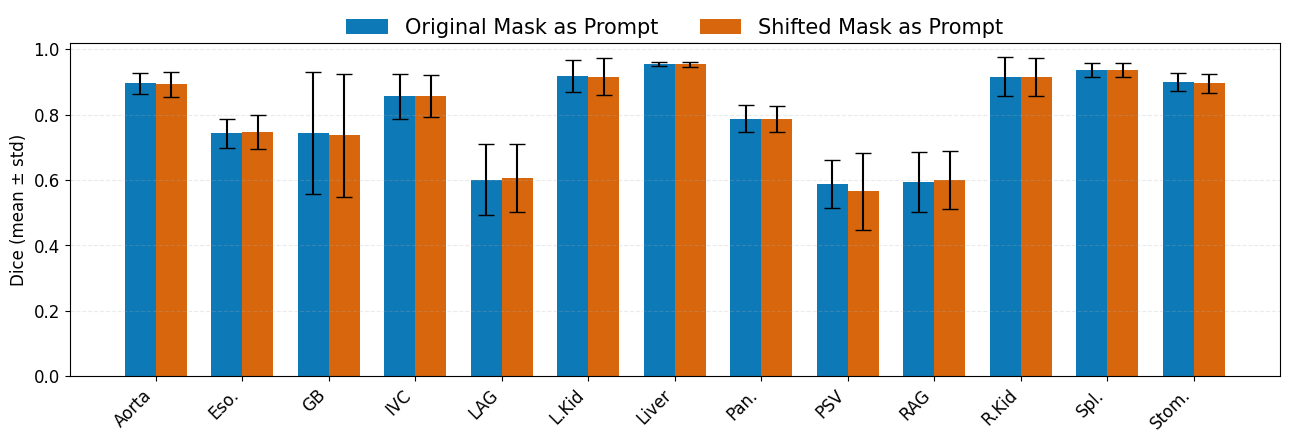

In [ ]:
# Double bar plot: noaug_nnint_organwise vs shift_nnint_organwise (CVPR-like colors)
# Expects: noaug_nnint_organwise, shift_nnint_organwise, abbr, os, np, plt available in the notebook.

# CVPR-style colors (consistent with earlier cells)
color_noaug = "#0072B2"   # blue
color_shift = "#D55E00"   # orange
na_color = "#CCCCCC"

# short name helper (reuse existing abbr mapping if present)
abbr_map =  {
    'right_kidney': 'R.Kid', 'left_kidney': 'L.Kid',
    'right_adrenal_gland': 'RAG', 'left_adrenal_gland': 'LAG',
    'portal_vein_and_splenic_vein': 'PSV', 'inferior_vena_cava': 'IVC',
    'gallbladder': 'GB', 'esophagus': 'Eso.',
    'spleen': 'Spl.', 'pancreas': 'Pan.',
    'stomach': 'Stom.', 'aorta': 'Aorta', 'liver': 'Liver'
}
short_name = lambda o: abbr_map.get(o, o.replace('_', ' ').title())

def _extract_vals(container, organ):
    """
    container: either dict[organ] -> list or dict[organ] -> dict with keys like 'no-aug'/'shift'
    returns numpy array (float) of values or empty array
    """
    v = container.get(organ, []) if isinstance(container, dict) else []
    if isinstance(v, dict):
        # prefer common keys
        for k in ('no-aug', 'noaug', 'no_aug', 'shift', 'shifted', 'shift_'):
            if k in v:
                return np.array(v[k] or [], dtype=float)
        # fallback: first list-like value
        for vv in v.values():
            if isinstance(vv, (list, tuple, np.ndarray)):
                return np.array(vv or [], dtype=float)
        return np.array([], dtype=float)
    elif isinstance(v, (list, tuple, np.ndarray)):
        return np.array(v or [], dtype=float)
    else:
        return np.array([], dtype=float)

def plot_noaug_vs_shift(noaug_dict, shift_dict, out_path, label_noaug='Original Mask as Prompt',
                        label_shift='Shifted Mask as Prompt'):
    # organs present in either dict
    orgs_all = sorted(list(set(list(noaug_dict.keys()) + list(shift_dict.keys()))))

    # compute means/stds
    means_noaug, stds_noaug = [], []
    means_shift, stds_shift = [], []
    for o in orgs_all:
        vals_o = _extract_vals(noaug_dict, o)
        svals_o = _extract_vals(shift_dict, o)

        means_noaug.append(np.nan if vals_o.size == 0 else float(np.mean(vals_o)))
        stds_noaug.append(0.0 if vals_o.size == 0 else float(np.std(vals_o)))

        means_shift.append(np.nan if svals_o.size == 0 else float(np.mean(svals_o)))
        stds_shift.append(0.0 if svals_o.size == 0 else float(np.std(svals_o)))

    means_noaug = np.array(means_noaug, dtype=float)
    stds_noaug = np.array(stds_noaug, dtype=float)
    means_shift = np.array(means_shift, dtype=float)
    stds_shift = np.array(stds_shift, dtype=float)

    # ordering: follow existing 'organs' variable if present, else sort by no-aug mean desc
    if 'organs' in globals() and isinstance(organs, list):
        order = [i for i, o in enumerate(orgs_all) if o in organs]
        if len(order) != len(orgs_all):
            sort_key = np.nan_to_num(means_noaug, nan=-1.0)
            order = np.argsort(-sort_key)
    else:
        sort_key = np.nan_to_num(means_noaug, nan=-1.0)
        order = np.argsort(-sort_key)

    order = np.array(order, dtype=int)
    orgs_ordered = [orgs_all[i] for i in order]

    means_noaug = means_noaug[order]
    stds_noaug = stds_noaug[order]
    means_shift = means_shift[order]
    stds_shift = stds_shift[order]

    os.makedirs(os.path.dirname(out_path) or ".", exist_ok=True)
    x = np.arange(len(orgs_ordered))
    width = 0.36

    fig, ax = plt.subplots(figsize=(13, 5))

    bars_noaug = ax.bar(x - width/2, np.nan_to_num(means_noaug, nan=0.0), width,
                        yerr=stds_noaug, error_kw={'ecolor': 'black', 'capsize': 6, 'elinewidth': 1.5},
                        label=label_noaug, color=color_noaug, edgecolor='none', alpha=0.95)
    bars_shift = ax.bar(x + width/2, np.nan_to_num(means_shift, nan=0.0), width,
                        yerr=stds_shift, error_kw={'ecolor': 'black', 'capsize': 6, 'elinewidth': 1.5},
                        label=label_shift, color=color_shift, edgecolor='none', alpha=0.95)

    # mark missing data (NaN means) with hatch + muted color
    for i in range(len(orgs_ordered)):
        if np.isnan(means_noaug[i]):
            bars_noaug[i].set_facecolor(na_color)
            bars_noaug[i].set_hatch('///')
            bars_noaug[i].set_edgecolor('#888888')
            bars_noaug[i].set_alpha(0.9)
        if np.isnan(means_shift[i]):
            bars_shift[i].set_facecolor(na_color)
            bars_shift[i].set_hatch('///')
            bars_shift[i].set_edgecolor('#888888')
            bars_shift[i].set_alpha(0.9)

    ax.set_xticks(x)
    ax.set_xticklabels([short_name(o) for o in orgs_ordered], rotation=45, ha='right', fontsize=12)
    ax.set_ylabel("Dice (mean ± std)", fontsize=12)
    ax.set_ylim(0.0, 1.02)
    ax.grid(axis='y', linestyle='--', alpha=0.25)
    ax.tick_params(axis='y', labelsize=12)

    ax.legend(frameon=False, ncol=2, fontsize=15, loc='upper center', bbox_to_anchor=(0.5, 1.13))

    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.savefig(out_path, dpi=600, format='pdf', bbox_inches='tight')
    print(f"Saved {out_path}")
    plt.show()

# call for existing nnInteractive dicts (keeps original filename)
# plot_noaug_vs_shift(noaug_nnint_organwise, shift_nnint_organwise, os.path.join("plots_shift", "nnint_noaug_vs_shift_cvpr.pdf"),
#                     label_noaug='Original Mask as Prompt', label_shift='Shifted Mask as Prompt')

# call for SAM-Med3D (their nested structure uses keys like 'no-aug' and 'shift')
plot_noaug_vs_shift(noaug_sammed3d, shift_sammed3d, os.path.join("plots_shift", "sammed3d_noaug_vs_shift_cvpr.pdf"),
                    label_noaug='Original Mask as Prompt', label_shift='Shifted Mask as Prompt')